### [실험 B] 활성화 함수 비교 :  ReLU vs LeakyReLU vs Sigmoid (스케쥴링 o)


### 실험 목표
  - ReLU, LeakyReLU, Sigmoid가 학습에 미치는 영향을 분석
  - Dead ReLU 발생 유도 및 LeakyReLU의 완화 효과 확인
  
---
"실험 설정" 주석이 달린 위치에서 활성화 함수마다의 결과 작동 가능능

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_moons, make_circles, load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#--------------------------------------------------------가중치조정정
batch_size = 64
epochs = 300
lr = 0.001

In [ ]:

# --------------------------------------------------------데이터 준비
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)


c:\Users\user\anaconda3\envs\dl_cuda126\lib\site-packages\sklearn\utils\_param_validation.py:14: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.23.1)
  from scipy.sparse import csr_matrix, issparse


Epoch 1/300, Loss: 0.6245, Test Acc: 0.8100
Epoch 2/300, Loss: 0.4203, Test Acc: 0.8500
Epoch 3/300, Loss: 0.3356, Test Acc: 0.8667
Epoch 4/300, Loss: 0.3103, Test Acc: 0.8700
Epoch 5/300, Loss: 0.2956, Test Acc: 0.8800
Epoch 6/300, Loss: 0.2874, Test Acc: 0.8867
Epoch 7/300, Loss: 0.2820, Test Acc: 0.8933
Epoch 8/300, Loss: 0.2764, Test Acc: 0.8900
Epoch 9/300, Loss: 0.2731, Test Acc: 0.8967
Epoch 10/300, Loss: 0.2694, Test Acc: 0.8933
Epoch 11/300, Loss: 0.2678, Test Acc: 0.8933
Epoch 12/300, Loss: 0.2630, Test Acc: 0.8967
Epoch 13/300, Loss: 0.2641, Test Acc: 0.9000
Epoch 14/300, Loss: 0.2585, Test Acc: 0.8933
Epoch 15/300, Loss: 0.2576, Test Acc: 0.9000
Epoch 16/300, Loss: 0.2557, Test Acc: 0.9000
Epoch 17/300, Loss: 0.2534, Test Acc: 0.9033
Epoch 18/300, Loss: 0.2521, Test Acc: 0.9033
Epoch 19/300, Loss: 0.2509, Test Acc: 0.9033
Epoch 20/300, Loss: 0.2501, Test Acc: 0.9067
Epoch 21/300, Loss: 0.2489, Test Acc: 0.9067
Epoch 22/300, Loss: 0.2486, Test Acc: 0.9067
Epoch 23/300, Loss:

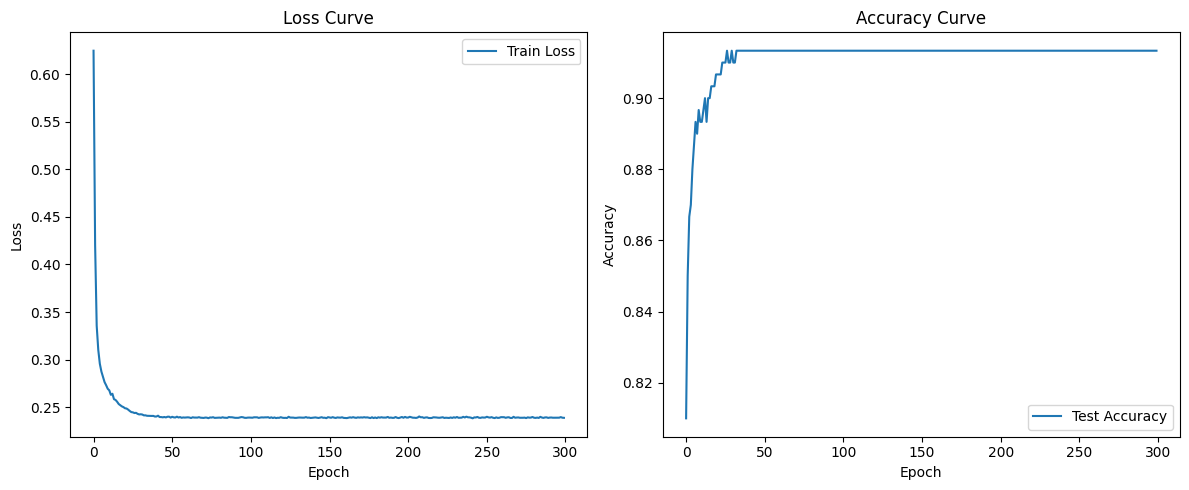

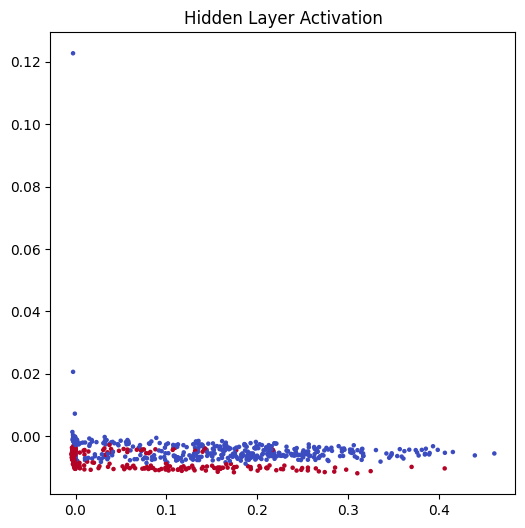

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------------------------------- 실험 설정
activation_type = 'leaky_relu'  # 'relu', 'leaky_relu', 'sigmoid'
optimizer_type = 'momentum'     # 'sgd', 'momentum', 'adam'
learning_rate = 0.001 if optimizer_type == 'adam' else 0.01
num_epochs = 300

# -------------------------------------------------------- 데이터셋 로드
X, y = make_moons(n_samples=1000, noise=0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                        torch.tensor(y_train, dtype=torch.long)), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                       torch.tensor(y_test, dtype=torch.long)), batch_size=64, shuffle=False)
input_size = 2
num_classes = 2

# -------------------------------------------------------- 모델 정의
def get_activation_fn(name):
    if name == 'relu':
        return nn.ReLU()
    elif name == 'leaky_relu':
        return nn.LeakyReLU()
    elif name == 'sigmoid':
        return nn.Sigmoid()

class MLP(nn.Module):
    def __init__(self, input_size, num_classes, activation_type):
        super(MLP, self).__init__()
        act_fn = get_activation_fn(activation_type)
        self.net = nn.Sequential(
            nn.Linear(input_size, 256),
            act_fn,
            nn.Linear(256, 128),
            act_fn,
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.net(x)

model = MLP(input_size, num_classes, activation_type)

# -------------------------------------------------------- 손실 함수&옵티마이저 선택택
loss_fn = nn.CrossEntropyLoss()

if optimizer_type == 'sgd':
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
elif optimizer_type == 'momentum':
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
elif optimizer_type == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# -------------------------------------------------------- 학습 루프
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for x_batch, y_batch in train_loader:
        outputs = model(x_batch)
        loss = loss_fn(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()
    train_losses.append(total_loss / len(train_loader))

    model.eval()
    correct = total = 0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            outputs = model(x_batch)
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
    acc = correct / total
    test_accuracies.append(acc)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Test Acc: {acc:.4f}")

# --------------------------------------------------------시각화
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.tight_layout()
plt.show()


# -------------------------------------------------------- 중간층 시각화
def visualize_hidden_layer(model, X, y):
    with torch.no_grad():
        x = torch.tensor(X, dtype=torch.float32)
        hidden_output = model.net[0](x)
        hidden_output = get_activation_fn(activation_type)(hidden_output)
        hidden_output = hidden_output.numpy()
        plt.figure(figsize=(6,6))
        plt.scatter(hidden_output[:, 0], hidden_output[:, 1], c=y, cmap='coolwarm', s=5)
        plt.title("Hidden Layer Activation")
        plt.show()

visualize_hidden_layer(model, X, y)


Epoch 1/300, Loss: 0.6423, Test Acc: 0.7567
Epoch 2/300, Loss: 0.4040, Test Acc: 0.8167
Epoch 3/300, Loss: 0.3297, Test Acc: 0.8267
Epoch 4/300, Loss: 0.3034, Test Acc: 0.8400
Epoch 5/300, Loss: 0.2915, Test Acc: 0.8600
Epoch 6/300, Loss: 0.2833, Test Acc: 0.8600
Epoch 7/300, Loss: 0.2796, Test Acc: 0.8667
Epoch 8/300, Loss: 0.2785, Test Acc: 0.8600
Epoch 9/300, Loss: 0.2764, Test Acc: 0.8800
Epoch 10/300, Loss: 0.2708, Test Acc: 0.8667
Epoch 11/300, Loss: 0.2699, Test Acc: 0.8667
Epoch 12/300, Loss: 0.2684, Test Acc: 0.8767
Epoch 13/300, Loss: 0.2661, Test Acc: 0.8700
Epoch 14/300, Loss: 0.2643, Test Acc: 0.8767
Epoch 15/300, Loss: 0.2647, Test Acc: 0.8833
Epoch 16/300, Loss: 0.2620, Test Acc: 0.8767
Epoch 17/300, Loss: 0.2603, Test Acc: 0.8833
Epoch 18/300, Loss: 0.2600, Test Acc: 0.8800
Epoch 19/300, Loss: 0.2581, Test Acc: 0.8833
Epoch 20/300, Loss: 0.2577, Test Acc: 0.8833
Epoch 21/300, Loss: 0.2571, Test Acc: 0.8833
Epoch 22/300, Loss: 0.2568, Test Acc: 0.8867
Epoch 23/300, Loss:

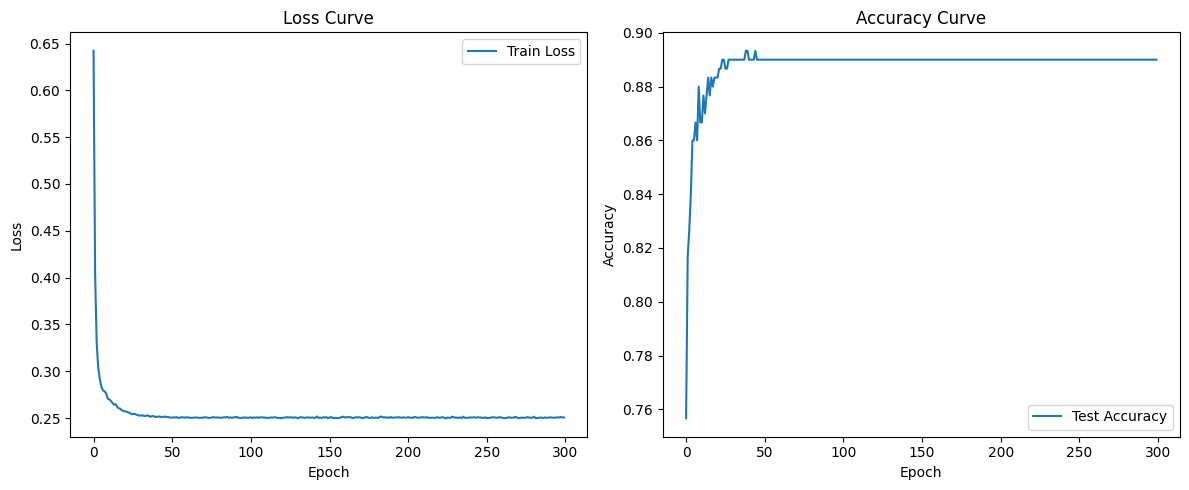

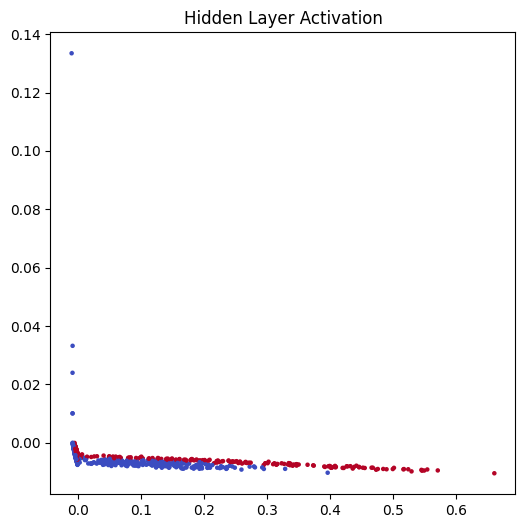

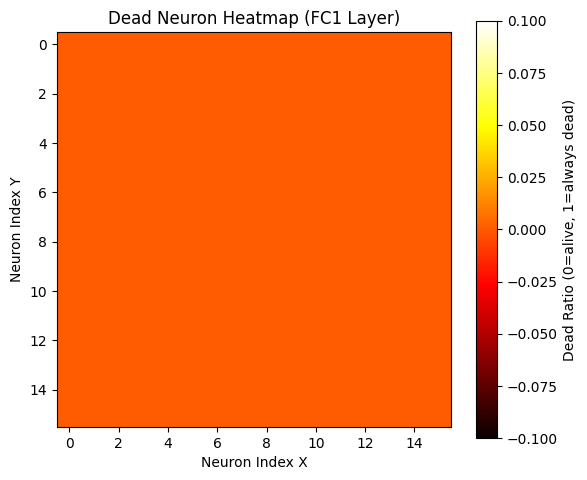

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

# 사용할 활성화 함수와 옵티마이저 선택
activation_type = 'leaky_relu'  # 'relu', 'leaky_relu', 'sigmoid' 중 선택 가능
optimizer_type = 'momentum'     # 'sgd', 'momentum', 'adam' 중 선택 가능

# 옵티마이저 종류에 따라 학습률 설정
learning_rate = 0.001 if optimizer_type == 'adam' else 0.01
num_epochs = 300  # 학습 횟수

# make_moons는 달 모양처럼 생긴 데이터 생성
X, y = make_moons(n_samples=1000, noise=0.2)

# 훈련용과 테스트용으로 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# 데이터를 파이토치 학습에 맞게 변환 (64개씩 묶어 처리)
train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                        torch.tensor(y_train, dtype=torch.long)), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                       torch.tensor(y_test, dtype=torch.long)), batch_size=64, shuffle=False)

# 입력 특징 개수와 분류할 클래스 수
input_size = 2
num_classes = 2

# 활성화 함수 설정 함수
def get_activation_fn(name):
    if name == 'relu':
        return nn.ReLU()
    elif name == 'leaky_relu':
        return nn.LeakyReLU()
    elif name == 'sigmoid':
        return nn.Sigmoid()

# MLP 모델 정의
class MLP(nn.Module):
    def __init__(self, input_size, num_classes, activation_type):
        super(MLP, self).__init__()
        act_fn = get_activation_fn(activation_type)
        self.net = nn.Sequential(
            nn.Linear(input_size, 256),  # 첫 번째 은닉층 (입력 → 256개 뉴런)
            act_fn,                      # 활성화 함수
            nn.Linear(256, 128),         # 두 번째 은닉층 (256 → 128)
            act_fn,
            nn.Linear(128, num_classes)  # 출력층 (128 → 클래스 수)
        )
    def forward(self, x):
        return self.net(x)

# 모델 생성
model = MLP(input_size, num_classes, activation_type)

#손실함수랑 옵티마이저 설정
loss_fn = nn.CrossEntropyLoss() 

# 선택한 옵티마이저 설정
if optimizer_type == 'sgd':
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
elif optimizer_type == 'momentum':
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
elif optimizer_type == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 학습률을 조금씩 줄이는 스케줄러 설정
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# 학습 루프
train_losses = []      # 에포크별 손실 저장
test_accuracies = []   # 에포크별 정확도 저장

for epoch in range(num_epochs):
    model.train()  # 학습 모드로 전환
    total_loss = 0

    # 배치 단위로 훈련
    for x_batch, y_batch in train_loader:
        outputs = model(x_batch)              # 예측값 계산
        loss = loss_fn(outputs, y_batch)      # 손실 계산

        optimizer.zero_grad()  # 이전 기울기 초기화
        loss.backward()        # 역전파
        optimizer.step()       # 파라미터 업데이트
        total_loss += loss.item()

    scheduler.step()  # 학습률 감소
    train_losses.append(total_loss / len(train_loader))

    # 테스트 정확도 측정
    model.eval()  # 평가 모드
    correct = total = 0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            outputs = model(x_batch)
            predicted = torch.argmax(outputs, dim=1)  # 가장 확률 높은 클래스 선택
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
    acc = correct / total
    test_accuracies.append(acc)

    # 현재 에포크 결과 출력
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Test Acc: {acc:.4f}")

# ==================== 학습 결과 시각화 ====================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.tight_layout()
plt.show()

# ==================== 은닉층 시각화 함수 ====================
def visualize_hidden_layer(model, X, y):
    with torch.no_grad():
        x = torch.tensor(X, dtype=torch.float32)
        hidden_output = model.net[0](x)  # 첫 번째 은닉층 통과
        hidden_output = get_activation_fn(activation_type)(hidden_output)
        hidden_output = hidden_output.numpy()
        plt.figure(figsize=(6,6))
        plt.scatter(hidden_output[:, 0], hidden_output[:, 1], c=y, cmap='coolwarm', s=5)
        plt.title("Hidden Layer Activation")
        plt.show()

visualize_hidden_layer(model, X, y)

# ==================== 죽은 뉴런(출력이 항상 0인 뉴런) 시각화 ====================
def plot_dead_neuron_heatmap(model, X, activation_type):
    with torch.no_grad():
        x = torch.tensor(X, dtype=torch.float32)
        fc1_output = model.net[0](x)  # 첫 번째 은닉층 통과
        activation = get_activation_fn(activation_type)
        activated_output = activation(fc1_output)

        # 뉴런이 죽었는지 확인 (출력이 항상 0인 비율)
        dead_ratio = (activated_output == 0).float().mean(dim=0).numpy()  # shape: (256,)

        # 16x16 히트맵으로 시각화
        heatmap_data = dead_ratio.reshape(16, 16)
        plt.figure(figsize=(6,5))
        plt.imshow(heatmap_data, cmap='hot', interpolation='nearest')
        plt.colorbar(label='Dead Ratio (0=alive, 1=always dead)')
        plt.title('Dead Neuron Heatmap (FC1 Layer)')
        plt.xlabel('Neuron Index X')
        plt.ylabel('Neuron Index Y')
        plt.tight_layout()
        plt.show()

plot_dead_neuron_heatmap(model, X, activation_type)
